In [1]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import sys
sys.path.append('..')  # Add parent directory to Python path
from article_dataset import ArticleDataset
from utils import custom_collate
from models.mlp_classifier import MLPClassifier
from models.bilstm_classifier import BiLSTMClassifier
from models.bilstmattention_classifier import BiLSTMAttentionClassifier

In [63]:
CSV_FILE = "../data/articles.csv"
FILTERS = {'min_freq': 5}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_classes = {
    'mlp': MLPClassifier,
    'bilstm': BiLSTMClassifier,
    'bilstm_att': BiLSTMAttentionClassifier
}

experiments = {
    'math_sub_cat':      {'selected_categories': ['math'], 'classification_level': 'sub_category', 'use_summary': True},
    'math_sub_cat_title':{'selected_categories': ['math'], 'classification_level': 'sub_category', 'use_summary': False},
    'summary_fulldb':    {'selected_categories': None,      'classification_level': 'category',     'use_summary': True},
    'title_fulldb':      {'selected_categories': None,      'classification_level': 'category',     'use_summary': False}
}

# Chargement de chaque modèle et dataset
loaded = {}
for arch_key, ModelClass in model_classes.items():
    for exp_suffix, cfg in experiments.items():
        exp_name = f"{arch_key}_{exp_suffix}"
        ckpt_path = os.path.join("..", "experiments", arch_key, exp_name, f"{exp_name}.pth")
        # Dataset
        ds = ArticleDataset(
            CSV_FILE,
            use_summary=cfg['use_summary'],
            classification_level=cfg['classification_level'],
            selected_categories=cfg['selected_categories']
        )
        ds.apply_filters(FILTERS)
        dl = DataLoader(ds, batch_size=32, collate_fn=custom_collate)
        # Chargement du checkpoint
        checkpoint = torch.load(ckpt_path, map_location=device)
        hparams = checkpoint['hyperparameters']
        state_dict = checkpoint['model_state_dict']
        # Détection automatique de l'architecture
        model = None
        for key, Cls in model_classes.items():
            try:
                tmp = Cls(
                    hparams['vocab_size'],
                    hparams['embedding_dim'],
                    hparams['hidden_dim'],
                    hparams['num_classes'],
                    hparams['num_hidden_layers'],
                    hparams['dropout']
                ).to(device)
                tmp.load_state_dict(state_dict)
                tmp.eval()
                model = tmp
                arch_detected = key
                break
            except RuntimeError:
                continue
        if model is None:
            raise RuntimeError(f"Impossible de charger {exp_name}: aucun modèle compatible n'a accepté le state_dict")
        loaded[exp_name] = {'dataset': ds, 'dataloader': dl, 'model': model, 'arch': arch_detected}

MemoryError: Unable to allocate 9.42 MiB for an array with shape (1, 1234798) and data type object

In [ ]:
experiment_name = 'bilstm_math_sub_cat'

model = loaded[experiment_name]['model']
dataloader = loaded[experiment_name]['dataloader']
device = next(model.parameters()).device
print(f"Architecture détectée : {loaded[experiment_name]['arch']}")

In [ ]:
def preprocess_text(text, wtoi):
    tokens = text.split()
    indices = [wtoi.get(token, wtoi.get("<UNK>", 0)) for token in tokens]
    return torch.tensor(indices, dtype=torch.long)

def predict(text, model, wtoi, device):
    input_tensor = preprocess_text(text, wtoi).unsqueeze(0).to(device)
    with torch.no_grad():
        return model(input_tensor)
    
test_title = "maths"
test_text = "The attention mechanism is a key component of transformer models, allowing them to focus on relevant parts of the input sequence."
predictions = predict(test_title, model_mlp_cat_title, dataset_mlp_cat_title.word_to_index, device)
predicted_class = torch.argmax(predictions, dim=1).item()
print(f"Predicted class for '{test_title}': {dataset_mlp_cat_title.index_to_class[predicted_class]}")

In [51]:
folder = "mlp"
experiment_name = "mlp_title_fulldb"
checkpoint_path = os.path.join('..', 'experiments', folder, experiment_name, f'{experiment_name}.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(checkpoint_path, map_location=device)
hparams = checkpoint['hyperparameters']
checkpoint.keys(), hparams.keys()

(dict_keys(['model_state_dict', 'hyperparameters', 'dataset_filters']),
 dict_keys(['vocab_size', 'embedding_dim', 'hidden_dim', 'num_classes', 'num_hidden_layers', 'dropout', 'freeze_embeddings']))

In [52]:
model_mlp_cat_title = MLPClassifier(
    vocab_size=hparams['vocab_size'],
    embedding_dim=hparams['embedding_dim'],
    hidden_dim=hparams['hidden_dim'],
    num_classes=hparams['num_classes'],
    num_hidden_layers=hparams['num_hidden_layers'],
    dropout=hparams['dropout']
).to(device)

model_mlp_cat_title.load_state_dict(checkpoint['model_state_dict'])
model_mlp_cat_title.eval()

MLPClassifier(
  (embedding): Embedding(38894, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (input_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=20, bias=True)
)

In [54]:
csv_file = "../data/articles.csv"
use_summary = False  
classification_level = "category"  # ou "sub_category"
selected_categories = None  # ou None pour toutes les catégories

dataset_mlp_cat_title = ArticleDataset(csv_file, use_summary=use_summary,
                         classification_level=classification_level,
                         selected_categories=selected_categories)
# appliquer mêmes filtres
filters = checkpoint.get('dataset_filters', {"min_freq": 5})
dataset_mlp_cat_title.apply_filters(filters)

# découpe train/test si nécessaire, mais ici on utilise tout pour inférence
test_loader = DataLoader(dataset_mlp_cat_title, batch_size=64, collate_fn=custom_collate)


In [66]:
def preprocess_text(text, wtoi):
    if isinstance(text, torch.Tensor):
        return text
    tokens = text.split()
    indices = [wtoi.get(token, wtoi.get("<UNK>", 0)) for token in tokens]
    return torch.tensor(indices, dtype=torch.long)

def predict(text, model, wtoi, device):
    input_tensor = preprocess_text(text, wtoi).unsqueeze(0).to(device)
    with torch.no_grad():
        return model(input_tensor)
    

test_vague_title = "on histograms and their applications in statistics "
predictions = predict(test_vague_title, model_mlp_cat_title, dataset_mlp_cat_title.word_to_index, device)
predicted_class = torch.argmax(predictions, dim=1).item()
print(f"Predicted class for '{test_vague_title}': {dataset_mlp_cat_title.index_to_class[predicted_class]}")

Predicted class for 'on histograms and their applications in statistics ': physics


In [70]:
# On collecte quelques erreurs de classification (jusqu'à 5 exemples)
misclassified = []
for text, true_label in dataset_mlp_cat_title:
    pred = torch.argmax(predict(text, model_mlp_cat_title, dataset_mlp_cat_title.word_to_index, device), dim=1).item()
    if pred != true_label:
        # cast tensor label to int so index_to_class[...] works
        label_int = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
        misclassified.append((text, label_int, pred))
    if len(misclassified) >= 20:
        break

# On affiche ces erreurs
for text, true_label, pred in misclassified:
    print(f"Texte       : {[dataset_mlp_cat_title.index_to_word[i.item()] for i in text]}")
    print(f"Vrai label  : {dataset_mlp_cat_title.index_to_class[true_label]}")
    print(f"Prédit label: {dataset_mlp_cat_title.index_to_class[pred]}")
    print("-" * 40)

Texte       : ['machine', 'learning', 'enhanced', 'calculation', 'of', 'quantum', 'classical', 'binding', 'free', 'energies']
Vrai label  : physics
Prédit label: quant-ph
----------------------------------------
Texte       : ['hierarchical', 'quantum', 'embedding', 'by', 'machine', 'learning', 'for', 'large', 'molecular', 'assemblies']
Vrai label  : physics
Prédit label: quant-ph
----------------------------------------
Texte       : ['les', 'houches', 'lectures', 'on', 'theoretical', 'ecology', 'high', 'dimensional', 'models', 'and', 'extreme', 'events']
Vrai label  : q-bio
Prédit label: stat
----------------------------------------
Texte       : ['statistical', 'physics', 'analysis', 'of', 'graph', 'neural', 'networks', 'approaching', 'optimality', 'in', 'the', 'contextual', 'stochastic', 'block', 'model']
Vrai label  : cond-mat
Prédit label: cs
----------------------------------------
Texte       : ['statistical', 'mechanics', 'of', 'semantic', 'compression']
Vrai label  : cond-mat

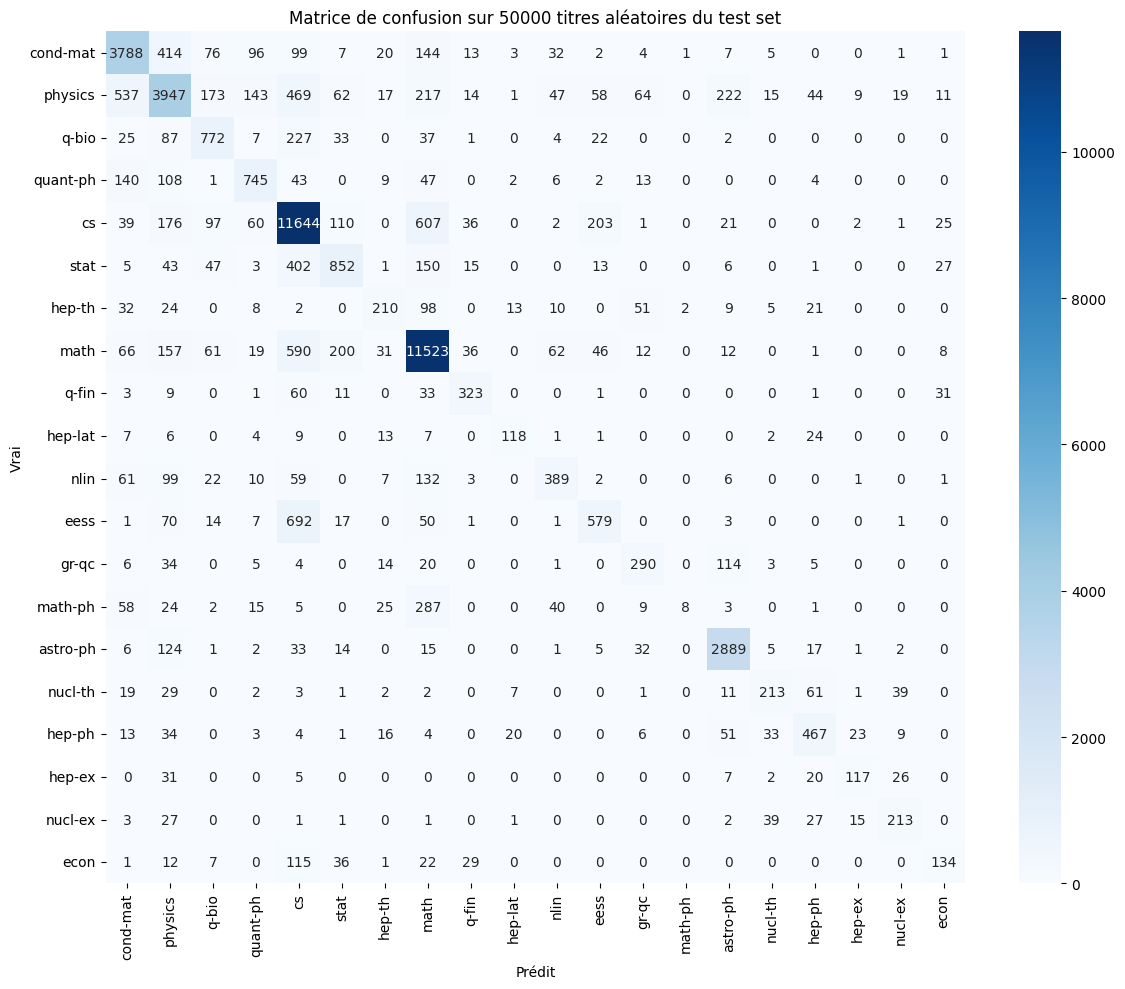

In [80]:
# Sélection aléatoire de 2000 échantillons
indices = torch.randperm(len(dataset_mlp_cat_title))[:50000].tolist()

y_true = []
y_pred = []
for idx in indices:
    text, true_label = dataset_mlp_cat_title[idx]
    true_int = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
    y_true.append(true_int)
    pred = torch.argmax(predict(text, model_mlp_cat_title, dataset_mlp_cat_title.word_to_index, device), dim=1).item()
    y_pred.append(pred)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
labels = [dataset_mlp_cat_title.index_to_class[i] for i in range(len(dataset_mlp_cat_title.index_to_class))]

# Affichage de la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion sur 50000 titres aléatoires du test set")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()